In [12]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit

## Reading the Files

In [13]:
#Observation 
result = fits.open('acisf09726_000N023_r0094u_lc3.fits')
print(result.info())
resolution = result[1].header['TIMEDEL']
print(f'Time resolution = {resolution} s')
date_start = result[1].header['DATE-OBS']
date_end = result[1].header['DATE-END']
print(f'Observation Timeline : {date_start} to {date_end}\n\n')

Filename: acisf09726_000N023_r0094u_lc3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU    163   2406R x 5C   [1D, 1D, 1D, 1D, 1D]   
  2  BKGLIGHTCURVE    1 BinTableHDU    169   0R x 5C   [1D, 1D, 1D, 1D, 1D]   
None
Time resolution = 16.686700046062 s
Observation Timeline : 2008-06-05T08:45:04 to 2008-06-05T20:19:44




## Extracting the Data

In [14]:
%matplotlib inline
#OBSERVATION 1
lc = result[1].data #Lightcurve
bg = result[2].data #Lightcurve

#arrays
time = lc['Time']
count_rate = lc['COUNT_RATE']
count_rate_err = lc['COUNT_RATE_ERR']

bg_count_rate = bg['COUNT_RATE']
bg_count_rate_err = bg['COUNT_RATE_ERR']

net_count_rate = count_rate - 0
net_err = [(count_rate_err[i]**2 + 0**2)**0.5 for i in range(len(count_rate_err))]

#starting time from zero
dt = time - time[0]

## Representing the Data

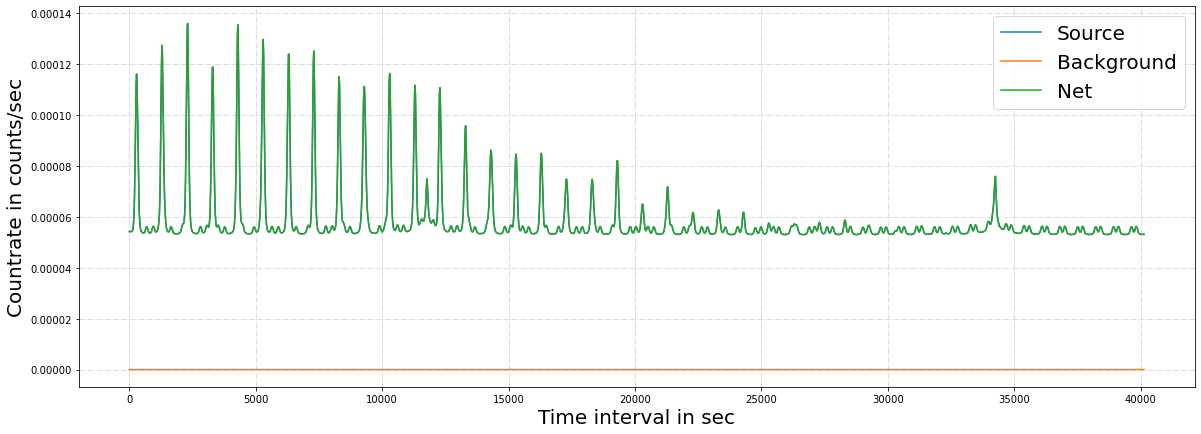

In [15]:
plt.figure(figsize = [20,7], facecolor = 'w')
plt.plot(dt, count_rate, label = 'Source')
plt.plot(dt, [0]*len(dt), label = 'Background')
plt.plot(dt, net_count_rate, label = 'Net')
#plt.errorbar(dt,count_rate, count_rate_err)
plt.grid(color = 'lightgrey', ls = '-.')
plt.xlabel('Time interval in sec', fontsize = 20)
plt.ylabel('Countrate in counts/sec', fontsize =20)
#plt.title(f'plot of {file_name}', fontsize = 20)
#plt.text(10000,2.8e-5, s = f'resolution = {resolution} s', fontsize = 20)
#plt.xlim(0,40000)
#plt.ylim(0,0.0009)
plt.legend(fontsize = 20)

## Binning the Data


Binned resolution is 100.120200276372s


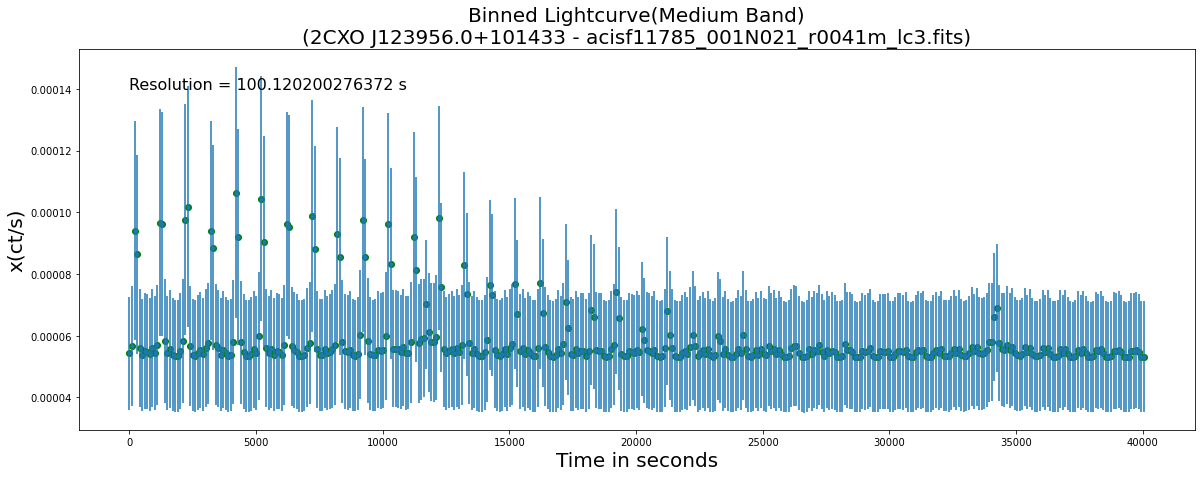

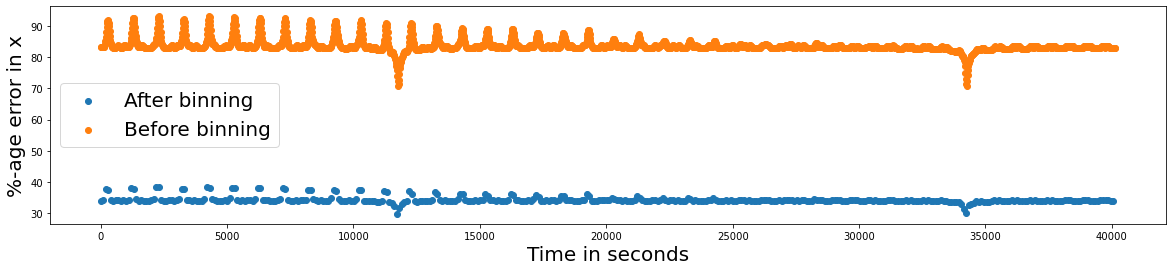

In [16]:
n_total = 2406 #Total data points
n_bin = 401 #Number of bins
bin_size = int(n_total/n_bin) #Bin size in units of data points
binned_resolution = bin_size*resolution
print(f'Binned resolution is {binned_resolution}s')

cr_binned = np.zeros(n_bin)
t_binned = np.zeros(n_bin)
err_binned = np.zeros(n_bin)

for i in range(n_bin):
    t_binned[i] = dt[bin_size*i]
for i in range(n_bin):
    sum_err_sq = 0
    for j in range((bin_size)):
        #summing and averaging all the counts 
        cr_binned[i] += net_count_rate[j+i*bin_size]/bin_size
        #summing square errors
        sum_err_sq += net_err[j+i*bin_size]**2 
    err_binned[i] = (sum_err_sq/bin_size**2)**0.5 

#Percentage error before and after binning
err_percent_binned = []
err_percent = []
for i in range(n_bin):
    err_percent_binned.append((err_binned[i]/cr_binned[i])*100)
for i in range(n_total):
    err_percent.append((net_err[i]/net_count_rate[i])*100)
    
plt.figure(figsize = [20,7], facecolor = 'w')
plt.scatter(t_binned,cr_binned,c='green')
plt.errorbar(t_binned, cr_binned, err_binned,fmt = '.')
plt.title('Binned Lightcurve(Medium Band)\n(2CXO J123956.0+101433 - acisf11785_001N021_r0041m_lc3.fits)', fontsize = 20)
plt.xlabel('Time in seconds', fontsize = 20)
plt.ylabel('x(ct/s)', fontsize = 20)
plt.text(0,0.00014,s=f'Resolution = {binned_resolution} s', fontsize = 16)
plt.figure(figsize = [20,4], facecolor = 'w')
plt.scatter(t_binned,err_percent_binned, label = 'After binning')
plt.scatter(dt[:n_total],err_percent, label = 'Before binning')
#plt.ylim(9.3,11)
plt.ylabel('%-age error in x', fontsize = 20)
plt.xlabel('Time in seconds', fontsize = 20)

plt.legend(fontsize = 20)

## Statistics from the Data

/tmp/ipykernel_5867/3966338700.py:32: RuntimeWarning: invalid value encountered in double_scalars
  F_var.append((Nxs_var[i]**0.5)*100)


Text(0.5, 0, 'Time in seconds')

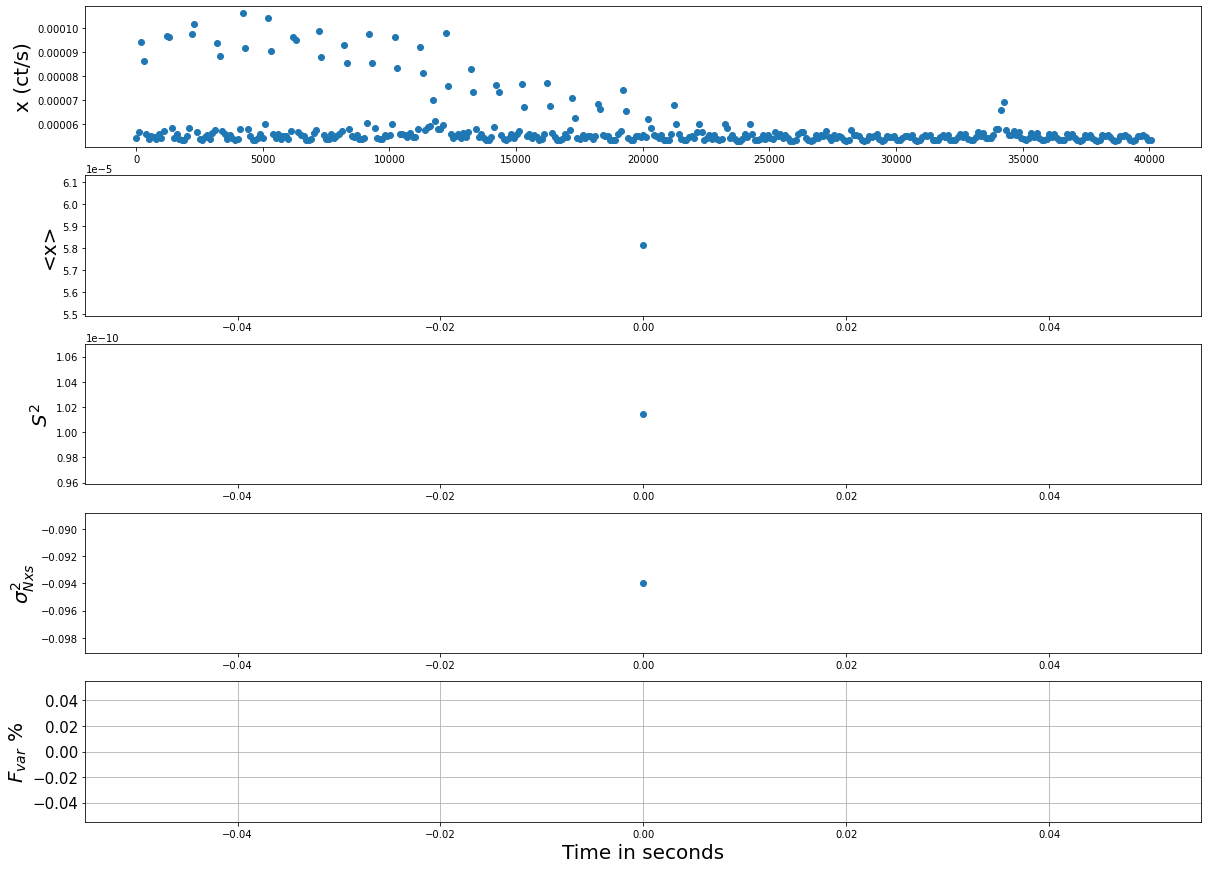

In [17]:
#MAKING AVG FLUX OF EVERY 20 POINTS
n_binned = 401#Total data points(already binned)
bin_size = 401#size of the bin in data points
n_points = int(n_binned/bin_size) #no. of data points

#print(n_points)
t_avg = [] #time for avg
c_avg = [] #avg count rate
for i in range(n_points):
    t_avg.append(t_binned[i*bin_size])
    sum = 0
    for j in range(bin_size):
        sum += cr_binned[j+i*bin_size]
    c_avg.append(sum/bin_size)
    
var = [] #variance
xs_var = [] #excess variance
Nxs_var = [] #Normalized excess variance
F_var = []
for i in range(n_points):
    sum = 0
    sum_err_sq = 0 #sum of squared err
    for j in range(0,bin_size):
        sum += (cr_binned[j+i*bin_size] - c_avg[i])**2
        sum_err_sq += (err_binned[j+i*bin_size])**2
    avg_sum_err_sq = sum_err_sq/bin_size
    #print('err ',avg_sum_err_sq)
    #print('var ',sum/19)
    var.append(sum/(bin_size - 1))
    xs_var.append(var[i] - avg_sum_err_sq)
    Nxs_var.append(xs_var[i]/c_avg[i]**2)
    F_var.append((Nxs_var[i]**0.5)*100)
    
#EXPECTATION VALUE OF VARIANCE
'''
expect_var = []
t_further = []
for i in range(7):
    sum = 0
    t_further.append(t_avg[i*20])
    for j in range(20):
        sum += var[j+i*20]
    expect_var.append(sum/20)
'''    
#PLOTTING
plt.figure(figsize = [20,15], facecolor = 'w')
ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)
ax1.scatter(t_binned, cr_binned)
ax1.set_ylabel('x (ct/s)', fontsize = 20)
ax2.scatter(t_avg, c_avg)
ax2.set_ylabel('<x>', fontsize = 20)
ax3.scatter(t_avg, var)
ax3.set_ylabel('$S^2$', fontsize = 20)
y = plt.yticks(fontsize = 15)
#ax3.set_yscale('log')
ax4.scatter(t_avg, Nxs_var)
ax4.set_ylabel('$σ_{Nxs}^2$', fontsize = 20)
plt.grid(True)
y = plt.yticks(fontsize = 15)
#ax4.set_yscale('log')
ax5.scatter(t_avg, F_var)
ax5.set_ylabel('$F_{var} $ %', fontsize = 20)
y = plt.yticks(fontsize = 15)
plt.xlabel('Time in seconds', fontsize = 20)

## Histogram of count rate


Text(0.5, 1.0, 'Count rate distribution of\n2CXO J123956.0+101433 - acisf11785_001N021_r0041m_lc3.fits')

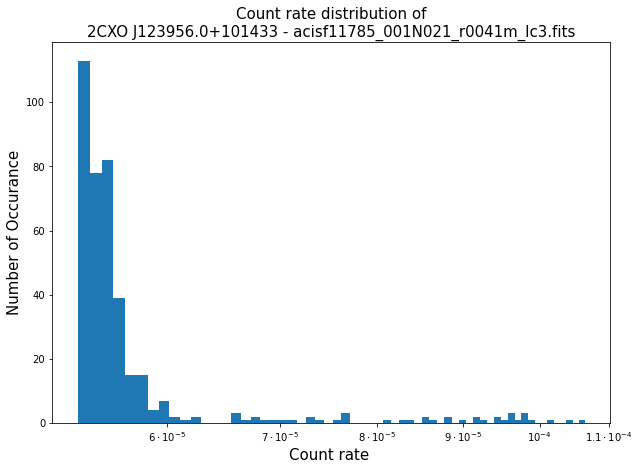

In [19]:
plt.figure(figsize = [10,7], facecolor = 'w')
plt.hist((cr_binned), bins = 60)
plt.xscale('logit')
plt.xlabel('Count rate ', fontsize = 15)
plt.ylabel('Number of Occurance', fontsize = 15)
plt.title('Count rate distribution of\n2CXO J123956.0+101433 - acisf11785_001N021_r0041m_lc3.fits', fontsize = 15)

### Gaussian ==>
# $ y = ae^{-\frac{(x-b)^2}{2c^2}}$

### Lorrentzian ==>
# $ y = a\frac{\frac{1}{2}\Gamma}{(x - x_0)^2 + (\frac{1}{2}\Gamma)^2}$

Goodness of fit for Gaussian 22.692802904004107 per dof
Goodness of fit for Lorrentzian 31.723716405412073 per dof


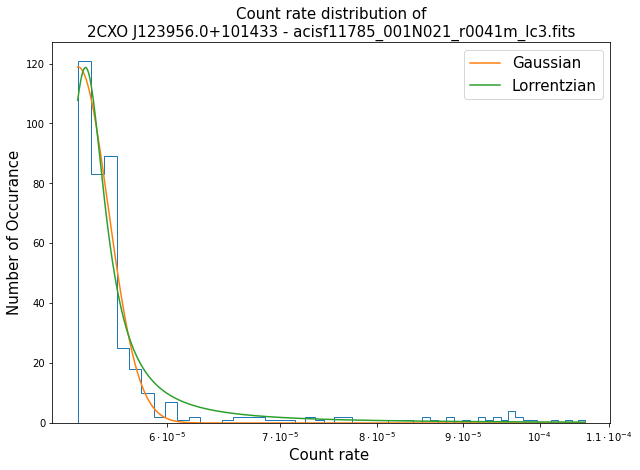

In [20]:
plt.figure(figsize = [10,7], facecolor = 'w')
distribution = plt.hist(cr_binned, bins = 55, histtype = 'step')
x = []
y = []
for i in range(len(distribution[0])):
    x_temp = np.linspace(distribution[1][i], distribution[1][i+1], 50)
    for j in range(len(x_temp)):
        x.append(x_temp[j])
        y.append(distribution[0][i])

def gaussian(x,a,b,c):
    exponent = -((x-b)**2/(2*c**2))
    return a*np.exp(exponent)

def lorrentzian(x,a,gamma,x_0):
    fraction = (0.5*gamma)/((x-x_0)**2 + (0.5*gamma)**2)
    result = a*fraction
    return result

param_g, pcov_g = curve_fit(gaussian, np.log10(x),y)
param_l, pcov_l = curve_fit(lorrentzian, np.log10(x),y)
plt.plot(x,gaussian(np.log10(x),param_g[0],param_g[1],param_g[2]), label = 'Gaussian')
plt.plot(x,lorrentzian(np.log10(x),param_l[0],param_l[1],param_l[2]), label = 'Lorrentzian')
plt.xscale('logit')
plt.legend(fontsize = 15)
plt.xlabel('Count rate ', fontsize = 15)
plt.ylabel('Number of Occurance', fontsize = 15)
plt.title('Count rate distribution of\n2CXO J123956.0+101433 - acisf11785_001N021_r0041m_lc3.fits', fontsize = 15)

least_sq_g = 0
least_sq_l = 0
for i in range(len(x)):
    least_sq_g += (gaussian(np.log10(x[i]),param_g[0],param_g[1],param_g[2])-y[i])**2
    least_sq_l += (lorrentzian(np.log10(x[i]),param_l[0],param_l[1],param_l[2])-y[i])**2
    
dof_g = len(x)-3
dof_l = len(x)-3
print(f'Goodness of fit for Gaussian {least_sq_g/dof_g} per dof')
print(f'Goodness of fit for Lorrentzian {least_sq_l/dof_l} per dof')